## Using Efficient Deep Learning to Classifying Disease Severity of COVID-19 Patients by using Saudi  X-ray Chest Images 

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [95]:
!pip install --user torchvision

In [96]:
%matplotlib inline
import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.6.0


# Preparing Training and Test Sets

In [97]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID_19_Radiography_Database'
source_dirs = ['NORMAL', 'Viral_Pneumonia', 'COVID_19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [98]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [99]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [100]:
train_dirs = {
    'normal': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/NORMAL',
    'viral': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/Viral_Pneumonia',
    'covid': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/COVID_19'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

FileNotFoundError: [Errno 2] No such file or directory: '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/NORMAL'

In [94]:
test_dirs = {
    'normal': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/NORMAL',
    'viral': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/Viral_Pneumonia',
    'covid': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/COVID_19'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

FileNotFoundError: [Errno 2] No such file or directory: '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/NORMAL'

In [64]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 485
Number of test batches 485


# Data Visualization

In [65]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

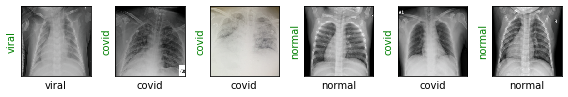

In [66]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

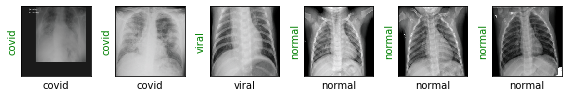

In [67]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [68]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [69]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [70]:
resnet18.fc

Linear(in_features=512, out_features=3, bias=True)

In [71]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

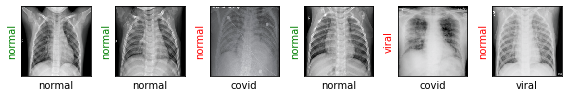

In [72]:
show_preds()

# Training the Model

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            #print(outputs)
            loss = loss_fn(outputs, labels)
            #print('loos',loss)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.99:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [79]:
labels

tensor([2, 2, 1, 0, 0, 0])

Starting training..
Starting epoch 1/2
tensor([[ 2.8877, -0.8407, -2.9591],
        [ 3.4635, -1.9455, -2.9032],
        [-2.6903, -1.4138,  3.7161],
        [-1.4052,  3.4669, -2.3756],
        [-2.0239, -2.1644,  4.0140],
        [-1.3437,  3.3699, -1.8594]], grad_fn=<AddmmBackward>)
Evaluating at step 0
Validation Loss: 0.0859, Accuracy: 0.9783


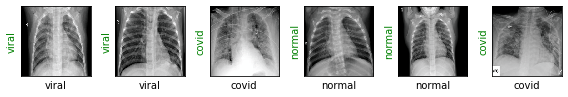

tensor([[ 2.2119,  1.2294, -3.3073],
        [-3.9714, -0.1716,  4.1664],
        [ 2.9946, -0.9474, -3.1976],
        [-1.3664, -0.1511,  0.6631],
        [-2.2760, -0.4549,  2.4530],
        [ 1.6228,  0.7493, -3.7015]], grad_fn=<AddmmBackward>)
tensor([[-2.4183, -2.3729,  4.8016],
        [ 2.9475, -2.2710, -1.5234],
        [-1.3741,  2.6403, -1.5175],
        [ 2.2307, -2.2772, -1.6181],
        [-1.4922,  2.7482, -1.3753],
        [-0.9261,  2.2865, -1.6444]], grad_fn=<AddmmBackward>)
tensor([[-2.0867,  2.3788, -0.6717],
        [-1.1153,  1.4297,  0.3129],
        [-1.1751,  2.1382, -1.2065],
        [-2.6385, -2.5004,  4.5873],
        [ 3.8327, -2.3969, -3.0220],
        [ 2.2632, -0.2984, -2.9251]], grad_fn=<AddmmBackward>)
tensor([[-0.8690,  3.0595, -2.3436],
        [-1.3449,  1.2572,  0.0723],
        [-1.4855, -4.0455,  4.8961],
        [-0.8527,  0.9635, -0.5236],
        [ 4.3837, -2.8703, -3.4148],
        [-0.8655,  2.2918, -1.3696]], grad_fn=<AddmmBackward>)
tensor([

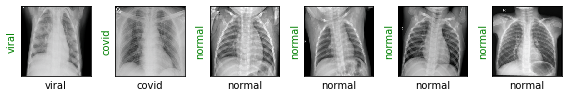

tensor([[-2.4164, -0.7689,  3.4972],
        [-1.5037,  4.1068, -2.3962],
        [ 3.0601, -1.5880, -2.7533],
        [ 3.1615, -1.5871, -2.9315],
        [ 0.3824,  1.1539, -2.0003],
        [-3.1347, -1.0229,  3.6014]], grad_fn=<AddmmBackward>)
tensor([[ 2.8312, -2.0696, -2.1521],
        [-5.0027,  0.3338,  5.0180],
        [ 1.4327, -2.4852, -0.1164],
        [-3.3569,  5.6189, -1.1949],
        [ 1.4203, -0.8810, -1.4141],
        [ 2.2117, -0.4032, -3.3376]], grad_fn=<AddmmBackward>)
tensor([[-1.4152,  0.0540,  0.8716],
        [-3.6624,  0.4424,  3.6648],
        [-1.7630,  0.5947,  1.1888],
        [ 3.5842, -0.4647, -4.6425],
        [ 3.4783,  0.5332, -5.5239],
        [-1.2232, -0.9458,  1.9634]], grad_fn=<AddmmBackward>)
tensor([[ 2.2677, -1.3234, -1.8475],
        [ 2.9743, -4.4194, -0.4744],
        [ 2.6916, -2.5328, -1.1697],
        [-3.1393,  3.1919,  0.9281],
        [-2.7113,  2.4264,  0.3273],
        [-2.4961,  3.0734, -0.8269]], grad_fn=<AddmmBackward>)
tensor([

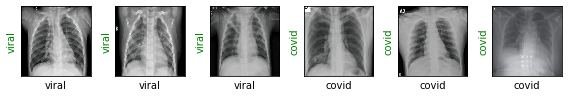

tensor([[ 3.2205, -2.7160, -2.7131],
        [-3.9109, -1.2381,  5.4363],
        [-1.5342,  2.7658, -1.0837],
        [-0.8510,  0.8591, -0.2356],
        [-2.6992,  4.5271, -1.7159],
        [ 4.8955, -3.4832, -2.8158]], grad_fn=<AddmmBackward>)
tensor([[-2.0498,  4.7328, -2.8638],
        [-3.1037, -0.5514,  3.6570],
        [-2.3717, -2.2388,  4.2511],
        [ 4.1464, -2.7794, -2.6842],
        [ 1.7417,  0.4157, -3.3908],
        [ 0.7641,  0.7902, -2.0800]], grad_fn=<AddmmBackward>)
tensor([[-3.0593,  1.4091,  1.8385],
        [ 2.7277,  1.2030, -4.6666],
        [ 1.6699,  0.0225, -2.0080],
        [-3.9636, -1.1909,  4.6767],
        [-0.4354,  0.3310, -0.1142],
        [ 2.3891, -1.3260, -3.0148]], grad_fn=<AddmmBackward>)
tensor([[-1.5265, -0.7461,  2.4812],
        [-0.3496, -2.0479,  1.9514],
        [ 0.2798,  3.7542, -5.3061],
        [ 1.3047, -1.6980, -0.5358],
        [-0.8780, -1.2967,  1.9880],
        [ 0.4115,  2.2432, -3.4674]], grad_fn=<AddmmBackward>)
tensor([

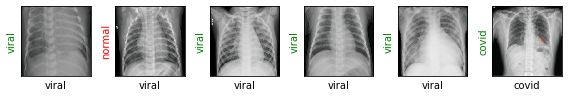

tensor([[-2.5737,  3.1570, -0.2341],
        [-3.4181,  2.9028,  1.9051],
        [-0.5425,  0.9064, -1.6198],
        [ 3.0430, -3.0448, -1.3580],
        [ 3.4952, -4.8089, -0.9442],
        [-0.8880,  1.5463, -0.7636]], grad_fn=<AddmmBackward>)
tensor([[-0.5046, -3.1484,  2.2489],
        [ 4.0717, -2.6758, -2.9260],
        [-2.1716, -1.9089,  3.7857],
        [-1.7236,  1.7185,  0.5409],
        [-0.4514,  3.4732, -3.2017],
        [ 0.1289,  2.7438, -3.3362]], grad_fn=<AddmmBackward>)
tensor([[ 1.4517, -0.4930, -1.8744],
        [-5.9942, -0.6763,  6.4133],
        [-0.8060,  1.9171, -1.5851],
        [-1.5765,  3.5462, -2.0397],
        [ 3.3632, -2.3009, -2.3043],
        [ 3.1190, -1.7699, -2.0674]], grad_fn=<AddmmBackward>)
tensor([[ 2.6456,  1.6077, -5.7115],
        [-2.9364, -0.4376,  3.0578],
        [ 5.1742, -1.0675, -5.4050],
        [-3.4870,  0.8412,  2.4365],
        [-2.0422,  0.6229,  1.6555],
        [-0.2522, -1.2376,  1.2269]], grad_fn=<AddmmBackward>)
tensor([

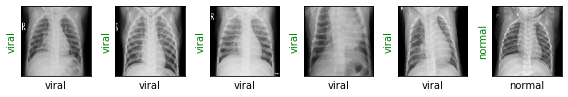

tensor([[ 0.3955, -0.4700, -1.0999],
        [ 3.1361, -1.8134, -2.6145],
        [-2.4183, -2.1772,  4.5323],
        [ 4.0812, -0.5949, -4.1428],
        [-3.9851,  0.8543,  3.5185],
        [-1.7644,  4.5539, -3.4500]], grad_fn=<AddmmBackward>)
tensor([[-2.0255,  1.6551,  0.6329],
        [ 0.5347,  1.3628, -2.4674],
        [ 4.2855, -4.6303, -1.8646],
        [ 0.4932,  1.9953, -2.4847],
        [-4.2038, -2.2620,  5.6726],
        [ 0.2004,  2.4920, -2.7404]], grad_fn=<AddmmBackward>)
tensor([[ 0.1346,  2.4545, -3.0612],
        [ 2.2023, -1.9384, -0.9038],
        [-3.1738, -1.1385,  4.4351],
        [ 0.8543,  2.7987, -5.1456],
        [ 3.7354, -2.3510, -2.6688],
        [-4.3830,  0.6757,  4.0618]], grad_fn=<AddmmBackward>)
tensor([[-1.8806, -3.0781,  4.7809],
        [ 3.8435, -1.0985, -3.9846],
        [-2.3340, -3.2757,  4.0479],
        [-0.6029,  3.7734, -3.3333],
        [-1.8397,  4.9048, -2.3034],
        [ 2.4047, -1.0547, -2.3395]], grad_fn=<AddmmBackward>)
tensor([

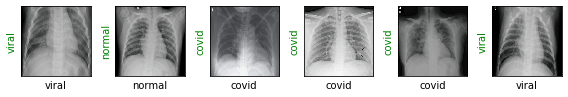

tensor([[-1.1177,  2.8788, -1.8309],
        [-1.3437,  3.5524, -1.6449],
        [ 2.3312, -1.4537, -1.5238],
        [-0.8109, -5.8295,  5.1418],
        [-0.9412,  3.1580, -2.7524],
        [ 1.3656, -1.4713, -1.0142]], grad_fn=<AddmmBackward>)
tensor([[-1.4988,  4.7486, -3.2618],
        [-0.9157,  3.7457, -3.0065],
        [-2.4721, -2.3418,  4.2830],
        [ 0.8118,  0.4549, -2.6583],
        [ 4.3769, -3.2534, -2.2138],
        [-0.9466, -2.7234,  3.3761]], grad_fn=<AddmmBackward>)
tensor([[-0.8881, -1.6359,  2.3248],
        [-1.0276, -1.0394,  1.9446],
        [ 3.8482,  0.4156, -5.8524],
        [-0.6181,  5.2742, -4.8955],
        [-2.5640,  0.4117,  1.6225],
        [ 0.6169, -2.8807,  1.8481]], grad_fn=<AddmmBackward>)
tensor([[-0.6822,  4.1985, -3.6822],
        [ 2.8129, -2.0394, -2.2162],
        [ 3.5619, -1.8775, -3.5745],
        [-3.5806, -0.3444,  3.9344],
        [-2.1862, -2.1451,  4.0492],
        [-0.7106,  2.7128, -1.7919]], grad_fn=<AddmmBackward>)
tensor([

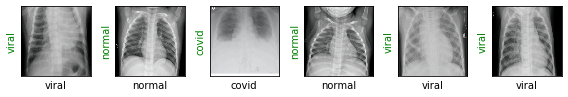

tensor([[ 0.1679, -2.2436,  1.0748],
        [ 0.0816,  3.6222, -4.0259],
        [-2.3352, -1.8379,  3.4161],
        [-0.9745, -0.2684,  0.7382],
        [ 1.3164,  3.7387, -5.4432],
        [ 0.5321, -2.2204,  1.1411]], grad_fn=<AddmmBackward>)
tensor([[-0.5302, -4.8981,  4.2636],
        [-0.8856,  4.2326, -2.9601],
        [-1.1861, -1.3825,  2.1694],
        [ 2.6625, -2.2782, -2.5733],
        [-2.1622,  3.3919, -0.6795],
        [ 1.2440,  2.0653, -3.7252]], grad_fn=<AddmmBackward>)
tensor([[-2.4380, -1.6376,  4.0684],
        [-0.4789, -2.7107,  2.6610],
        [-2.7733, -1.4321,  3.9649],
        [ 2.4234,  0.9471, -5.1875],
        [-0.6242,  5.2849, -4.0687],
        [ 3.0625,  0.4230, -5.0206]], grad_fn=<AddmmBackward>)
tensor([[-1.7102,  4.8561, -2.6015],
        [-1.9048, -3.9780,  5.1307],
        [-2.5211, -2.0690,  3.5670],
        [ 2.7174, -0.4150, -2.5414],
        [ 1.9166,  0.2538, -3.7293],
        [ 0.5465,  2.4972, -3.5508]], grad_fn=<AddmmBackward>)
tensor([

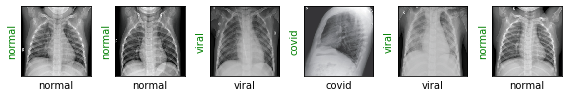

tensor([[ 2.4131, -0.7454, -2.8376],
        [ 1.5464, -0.4046, -1.6676],
        [ 1.9703, -1.1030, -1.7316],
        [-5.4986, -0.8393,  6.2210],
        [-1.7756,  4.2948, -2.4116],
        [ 0.7884, -0.2962, -1.4193]], grad_fn=<AddmmBackward>)
tensor([[ 1.3368, -3.4752,  0.3915],
        [-2.7329,  3.6050, -0.4299],
        [-2.2596,  2.4393, -0.3029],
        [-0.2647,  0.4740, -0.2942],
        [-0.5612,  1.5764, -0.8684],
        [ 3.3719, -3.4926, -1.8783]], grad_fn=<AddmmBackward>)
tensor([[-0.8817,  3.4902, -2.9902],
        [-1.0938, -4.3391,  3.8841],
        [-2.0615, -2.8941,  4.4379],
        [ 0.4401,  2.5837, -3.0718],
        [-1.2890,  4.1473, -2.4929],
        [ 4.0711, -2.0040, -3.2929]], grad_fn=<AddmmBackward>)
tensor([[-1.0602,  2.9849, -1.8487],
        [ 3.0763, -1.6522, -2.2842],
        [-1.9355,  3.7738, -1.8423],
        [-0.3294,  2.8987, -2.8505],
        [ 2.5553, -2.9921, -1.2167],
        [-3.0949, -3.5412,  6.2219]], grad_fn=<AddmmBackward>)
tensor([

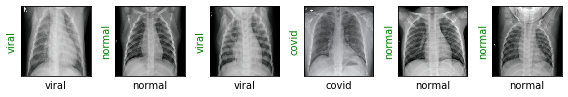

tensor([[-2.9036, -0.9818,  3.6554],
        [-1.0204,  3.2244, -1.6276],
        [-1.7173,  3.8369, -2.2431],
        [ 1.7883,  0.0483, -2.8846],
        [-1.0517, -3.1884,  3.6956],
        [ 4.0634, -1.9631, -4.0882]], grad_fn=<AddmmBackward>)
tensor([[-1.6714, -2.3094,  2.6052],
        [ 3.1921,  0.9250, -4.4834],
        [ 3.7591, -3.2722, -2.2557],
        [-2.4331,  4.0884, -0.9421],
        [-3.4232, -1.8785,  4.7205],
        [-0.2074,  3.3950, -3.4084]], grad_fn=<AddmmBackward>)
tensor([[-1.9218, -2.1453,  3.8240],
        [-0.2898,  3.7993, -4.0422],
        [ 4.5936, -0.8249, -5.1574],
        [-2.1530, -0.8728,  2.7053],
        [-1.4209, -2.0370,  2.6072],
        [ 0.0733,  2.9048, -3.2343]], grad_fn=<AddmmBackward>)
tensor([[-1.4833,  2.6890, -0.8448],
        [ 0.5349,  2.9254, -4.1338],
        [ 4.0045, -2.8742, -2.2913],
        [-0.5639, -4.0471,  3.4035],
        [-3.6133, -0.6410,  3.6618],
        [ 0.1158,  2.6822, -3.0348]], grad_fn=<AddmmBackward>)
tensor([

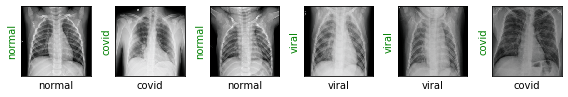

tensor([[-1.4180,  3.8579, -1.3268],
        [-0.5583,  3.6559, -3.8058],
        [-2.1669, -2.2666,  3.7939],
        [-3.7282, -1.2752,  4.8240],
        [ 3.2467, -1.3824, -3.3136],
        [ 3.6214, -1.9842, -3.1229]], grad_fn=<AddmmBackward>)
tensor([[-2.1025, -0.8515,  2.7305],
        [-0.1816,  4.5877, -4.7097],
        [-1.4967, -1.4115,  2.7930],
        [-2.0922, -0.9985,  2.7450],
        [ 5.4573,  0.6157, -7.3857],
        [-1.0251, -1.4035,  1.3204]], grad_fn=<AddmmBackward>)
tensor([[-0.8729, -2.5926,  2.7407],
        [ 0.2486,  3.9982, -3.3958],
        [ 2.3600,  1.5007, -4.5423],
        [-0.7583,  4.2221, -4.1179],
        [-0.2970, -3.1287,  2.5461],
        [-1.9135, -3.3806,  3.8905]], grad_fn=<AddmmBackward>)
tensor([[ 1.8414, -0.2372, -2.1795],
        [-1.2235,  4.1884, -3.3940],
        [-3.6478, -1.5187,  4.9312],
        [-0.9369,  3.8797, -2.5490],
        [-1.6184, -3.7023,  4.0287],
        [ 4.4542, -2.0452, -3.7720]], grad_fn=<AddmmBackward>)
tensor([

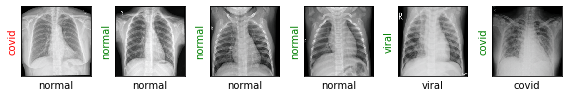

tensor([[ 3.7159, -2.5089, -3.6194],
        [-1.4823, -1.2273,  1.9500],
        [-3.4530, -0.5846,  4.1565],
        [-1.1471,  4.9372, -3.0731],
        [-2.5766, -0.5859,  2.7085],
        [ 3.5713,  0.8565, -5.1093]], grad_fn=<AddmmBackward>)
tensor([[-0.0486, -3.3347,  2.9890],
        [ 0.3192,  2.0190, -2.7959],
        [-2.6300, -1.0772,  4.1698],
        [-0.8876,  6.2084, -5.4327],
        [-0.9875, -2.1910,  2.2304],
        [ 3.0580, -0.9081, -4.0487]], grad_fn=<AddmmBackward>)
tensor([[-2.3174,  2.4626,  0.1437],
        [-3.0414, -3.4942,  5.2861],
        [-1.8209,  3.1276, -1.0332],
        [ 2.5650, -1.1493, -2.4660],
        [ 1.5277,  1.0656, -3.5699],
        [ 1.9101, -1.1567, -1.8301]], grad_fn=<AddmmBackward>)
tensor([[ 0.1888,  0.6182, -1.5752],
        [ 1.3188,  1.1744, -3.6381],
        [ 1.4111, -0.6087, -1.6147],
        [-4.7870, -1.0858,  6.1479],
        [-0.4732,  0.7122, -0.8697],
        [ 1.1440,  0.0524, -1.9314]], grad_fn=<AddmmBackward>)
tensor([

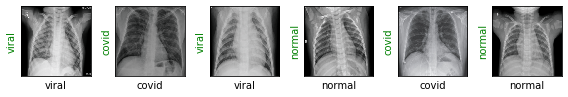

tensor([[-0.1886,  1.5625, -1.8268],
        [-3.2060, -2.6547,  5.6021],
        [ 2.0966, -1.0543, -2.2321],
        [ 2.4602, -2.0459, -2.0420],
        [-2.3404,  3.8427, -1.1851],
        [ 0.4306,  1.4597, -2.0184]], grad_fn=<AddmmBackward>)
tensor([[ 2.4202, -4.1037, -0.5283],
        [-1.4973,  4.6433, -2.1542],
        [ 2.8104, -1.8140, -2.4272],
        [ 1.7553,  0.1593, -2.3840],
        [-2.4692,  4.8446, -2.1657],
        [-3.9638, -2.8924,  6.3730]], grad_fn=<AddmmBackward>)
tensor([[ 3.9869, -1.4783, -4.0793],
        [ 0.8535,  2.3483, -3.5234],
        [-1.4936, -3.5451,  3.1654],
        [-1.0162,  2.8464, -2.0370],
        [-1.8229, -3.4328,  5.4066],
        [-1.7282,  4.3083, -2.3294]], grad_fn=<AddmmBackward>)
tensor([[ 0.7805,  0.1469, -2.1619],
        [-3.4356, -1.8232,  5.9716],
        [-0.4758,  2.6885, -2.4644],
        [-2.3253,  4.0900, -1.7518],
        [ 0.5893,  0.3394, -1.4257],
        [ 3.9026, -4.4733, -1.8554]], grad_fn=<AddmmBackward>)
tensor([

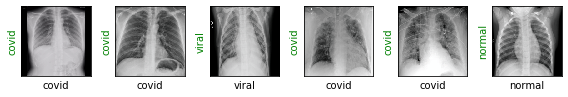

tensor([[-1.2420,  2.8042, -1.3997],
        [-4.1700, -1.2759,  5.0350],
        [ 3.0581, -2.1486, -2.3948],
        [ 3.5269, -3.0959, -1.8825],
        [-3.2818,  5.3369, -1.0658],
        [ 1.4232, -1.0073, -1.7156]], grad_fn=<AddmmBackward>)
tensor([[ 0.9871, -1.7356, -0.7050],
        [ 2.6410, -2.1769, -1.8479],
        [ 2.8244, -3.0176, -1.7911],
        [-2.0705,  3.7603, -1.2329],
        [-3.5257,  5.9105, -0.6848],
        [-1.7115, -2.2039,  2.9794]], grad_fn=<AddmmBackward>)
tensor([[-0.7308, -3.2168,  3.2763],
        [-0.7846,  1.5952, -1.5917],
        [-1.0664,  4.5618, -3.1617],
        [-2.8851, -2.3177,  4.6658],
        [ 3.4132, -2.6956, -2.6684],
        [ 0.8586,  2.5549, -3.6435]], grad_fn=<AddmmBackward>)
tensor([[-4.6947, -2.5429,  6.8512],
        [ 0.8363,  0.6328, -1.6257],
        [ 3.0623, -3.7388, -0.8266],
        [ 1.9780, -0.6782, -2.7883],
        [-0.3096,  2.9908, -2.8805],
        [-1.7663,  4.3249, -2.4384]], grad_fn=<AddmmBackward>)
tensor([

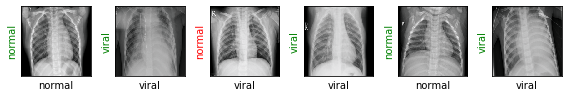

tensor([[ 3.2395e+00, -1.2835e+00, -2.7788e+00],
        [-2.8628e+00,  4.0599e+00, -5.0060e-03],
        [-2.3215e-01,  2.1789e+00, -2.7764e+00],
        [-3.6911e+00, -2.5529e+00,  5.2075e+00],
        [-3.4032e-01,  6.7320e-01, -8.5518e-01],
        [ 3.0442e+00, -2.4841e+00, -2.3072e+00]], grad_fn=<AddmmBackward>)
tensor([[-1.9414, -3.0742,  4.2339],
        [ 5.1677,  0.1081, -7.3574],
        [-2.4711,  0.1207,  2.1183],
        [-2.0340,  0.0579,  1.2366],
        [-3.7485,  2.7210,  1.9867],
        [ 3.3436,  0.6090, -4.8982]], grad_fn=<AddmmBackward>)
tensor([[-1.1251,  3.8633, -2.5327],
        [ 2.4455, -0.0316, -3.6657],
        [-3.5776, -1.4372,  5.0559],
        [ 4.1803, -1.2195, -4.7763],
        [-1.0188,  3.3783, -1.6605],
        [-2.0272, -3.7924,  4.3718]], grad_fn=<AddmmBackward>)
tensor([[-3.1445,  0.3695,  2.4927],
        [ 3.6358, -0.8571, -3.9477],
        [ 0.7073,  2.8986, -4.0469],
        [-3.4336, -1.0353,  3.9558],
        [ 4.6668,  0.2862, -6.2012],

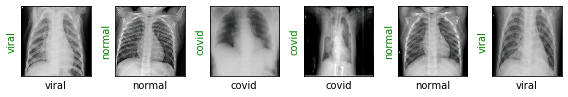

tensor([[ 3.9470,  1.0617, -6.0170],
        [-2.3281, -1.3924,  3.0181],
        [ 1.6020,  0.9629, -3.4332],
        [-4.1775,  0.0692,  3.9572],
        [ 2.9327,  1.0072, -4.8281],
        [-3.0122, -1.3825,  4.4212]], grad_fn=<AddmmBackward>)
tensor([[-2.5463,  3.0982, -0.4747],
        [ 3.3617, -0.1881, -4.6836],
        [-5.1753, -1.5594,  7.1773],
        [ 2.0834, -1.9244, -1.3653],
        [ 3.4055, -1.8467, -2.5152],
        [-1.5888,  3.1064, -1.7173]], grad_fn=<AddmmBackward>)
tensor([[-4.6388, -0.7079,  5.1313],
        [ 2.1359,  0.0123, -2.7498],
        [-2.2019,  4.6937, -2.4008],
        [ 4.4617, -0.9881, -5.0408],
        [ 2.9747, -0.4853, -3.2914],
        [-3.5768, -1.8157,  4.9460]], grad_fn=<AddmmBackward>)
tensor([[ 3.6769,  0.5699, -5.1807],
        [-3.0127, -1.3880,  3.9208],
        [ 1.5821, -3.3011,  0.7229],
        [-1.7732,  5.6036, -3.4739],
        [ 0.8325,  1.4171, -2.9465],
        [-2.2061, -2.4297,  3.8679]], grad_fn=<AddmmBackward>)
tensor([

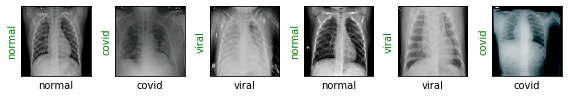

tensor([[-2.6057,  3.9705, -0.7468],
        [ 4.2679, -3.0173, -3.2592],
        [ 0.3965,  2.3286, -3.2902],
        [-2.1652,  3.4472, -1.1503],
        [-1.0495, -5.7203,  5.3695],
        [ 0.1168, -0.0506, -0.4907]], grad_fn=<AddmmBackward>)
tensor([[ 1.0497e+00,  2.1260e+00, -4.0968e+00],
        [ 3.1277e+00, -4.2442e-01, -4.4685e+00],
        [-3.1643e+00,  4.0455e+00, -1.8448e-03],
        [-1.6316e+00, -1.1326e+00,  3.9535e+00],
        [-3.7429e+00, -3.2726e+00,  5.5253e+00],
        [ 3.4748e+00, -5.6781e-01, -4.4654e+00]], grad_fn=<AddmmBackward>)
tensor([[ 2.1185,  0.3452, -3.7510],
        [ 0.9754, -1.4124, -0.5863],
        [-2.1056,  4.6109, -1.1304],
        [-2.9378, -4.5826,  6.2072],
        [-1.3220,  3.5448, -2.3775],
        [ 2.6283, -1.9306, -2.0605]], grad_fn=<AddmmBackward>)
tensor([[-1.6622,  4.6090, -2.4958],
        [ 2.8911, -2.2104, -1.6334],
        [-2.3191, -5.5936,  6.1486],
        [ 3.5525, -2.9045, -2.3083],
        [-1.5690,  4.1881, -2.3735],

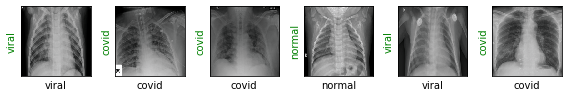

tensor([[ 3.7779, -1.8029, -3.3653],
        [ 1.8230,  1.3780, -3.8485],
        [-3.7416, -3.1479,  6.4566],
        [-3.6692,  4.2632, -0.2392],
        [-1.2149,  1.4547, -0.5687],
        [ 2.4167, -1.4491, -2.1934]], grad_fn=<AddmmBackward>)
tensor([[ 3.7323, -0.8741, -4.1197],
        [ 0.8665,  1.4089, -2.7474],
        [-4.5433,  0.0116,  4.7145],
        [-5.9420,  0.0084,  5.7247],
        [ 1.9807,  0.7849, -3.2394],
        [ 3.3860, -0.6284, -4.1325]], grad_fn=<AddmmBackward>)
tensor([[ 0.8538,  1.2573, -2.0384],
        [-2.1363,  3.3708, -1.3863],
        [ 3.7448, -4.3718, -1.2329],
        [-1.6581,  3.1790, -1.1825],
        [-1.2935, -4.8671,  4.5470],
        [-0.6927,  2.6318, -2.1809]], grad_fn=<AddmmBackward>)
tensor([[ 2.2201, -2.9135, -0.9258],
        [-2.3677,  2.3755,  0.3751],
        [ 2.0088, -3.3236,  0.0530],
        [-2.0118,  3.3143, -1.2714],
        [-2.3486,  3.5679, -0.9241],
        [ 1.6582, -2.5187, -0.7794]], grad_fn=<AddmmBackward>)
tensor([

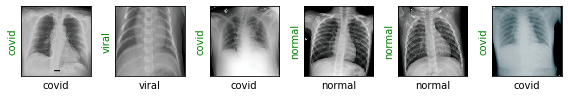

tensor([[ 4.1076, -0.6366, -4.9086],
        [-2.0359,  3.6664, -0.9515],
        [-1.1208,  3.5843, -1.9547],
        [-2.6383, -2.6907,  4.6845],
        [-3.6194, -2.3373,  4.6145],
        [ 4.5811, -1.1387, -4.7999]], grad_fn=<AddmmBackward>)
tensor([[-1.7594, -1.2880,  3.0498],
        [-1.0309, -2.6679,  2.5665],
        [ 6.3422, -3.2653, -5.2881],
        [-1.2346,  4.9012, -3.5912],
        [ 1.2925,  2.6427, -4.2220],
        [-4.5665,  0.2349,  4.6430]], grad_fn=<AddmmBackward>)
tensor([[-3.6993,  5.2211, -0.5091],
        [ 4.0657, -3.4680, -1.7200],
        [ 0.4376,  1.4659, -2.7317],
        [-5.5576, -1.2961,  6.2282],
        [ 3.1955, -2.0527, -2.2009],
        [ 1.1401,  0.3570, -2.7055]], grad_fn=<AddmmBackward>)
tensor([[-3.3730e+00, -3.0227e-03,  3.3594e+00],
        [ 5.9388e+00,  4.6639e-01, -7.6667e+00],
        [-1.8758e+00, -1.8836e+00,  3.5547e+00],
        [-2.0439e+00, -4.1781e-01,  2.0113e+00],
        [ 9.7281e-01,  4.4761e+00, -6.4313e+00],
        [-7

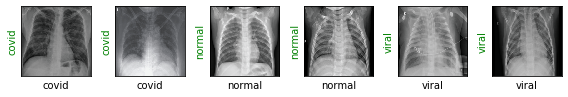

Performance condition satisfied, stopping..
CPU times: user 51min 46s, sys: 20 s, total: 52min 6s
Wall time: 52min 41s


In [80]:
%%time

train(epochs=2)

# Final Results

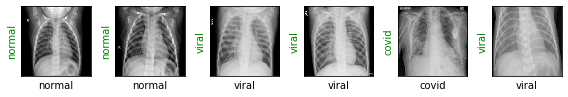

In [75]:
show_preds()

# Result Analysis 

Starting training..
Starting epoch 1/300
tensor([[-2.1038, -1.7713,  3.7044],
        [-0.3470,  3.7088, -3.3044],
        [-3.6425,  0.3405,  3.3626],
        [ 5.6713,  2.3807, -9.1752],
        [ 0.3354, -4.3186,  2.1648],
        [-1.2824,  0.1910,  0.9413]], grad_fn=<AddmmBackward>)
Evaluating at step 0
Validation Loss: 0.0463, Accuracy: 0.9876


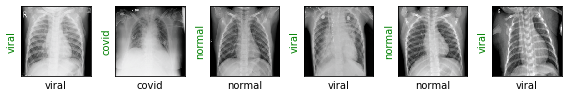

tensor([[ 0.6642, -4.0024,  1.6838],
        [ 3.2939, -4.3882, -0.9046],
        [ 2.5415, -0.5117, -2.7798],
        [-2.9814,  3.6127, -0.0103],
        [-4.5291,  5.1837,  0.1840],
        [ 0.0349,  0.7886, -1.4694]], grad_fn=<AddmmBackward>)
tensor([[-1.5128, -0.9008,  2.7461],
        [-0.9274,  6.4208, -5.2597],
        [-2.9097, -1.5369,  3.2806],
        [-4.5862, -1.5229,  5.4474],
        [ 4.4118, -0.6411, -4.6995],
        [ 4.4386, -1.6757, -4.1308]], grad_fn=<AddmmBackward>)
tensor([[ 3.9081,  2.5649, -7.8085],
        [-0.6824,  4.0092, -3.1610],
        [-2.0252, -2.5413,  3.7643],
        [-0.2345,  3.1180, -2.8495],
        [-1.5780, -3.0963,  3.7302],
        [-0.5175, -3.4103,  3.4863]], grad_fn=<AddmmBackward>)
tensor([[ 3.3361, -2.0125, -2.7124],
        [ 2.7275, -2.8796, -1.7899],
        [-4.4422,  6.0350, -0.6324],
        [ 2.9974,  0.2530, -3.2644],
        [-5.8222, -1.2370,  6.7333],
        [ 0.7706,  0.2090, -1.8454]], grad_fn=<AddmmBackward>)
tensor([

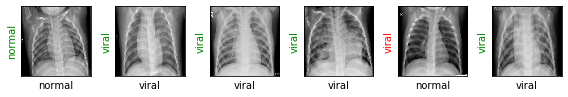

Performance condition satisfied, stopping..


In [81]:
train(epochs=300)

In [ ]:
resnet18.summary()